In [143]:
import numpy as np
from os import path
import matplotlib.pyplot as plt
from scipy.stats import entropy
from os import listdir
import pandas as pd
from sklearn.metrics import RocCurveDisplay,roc_curve,DetCurveDisplay

In [144]:
#load input cross-val data
tp_data = np.load(path.abspath("target_present_data.npz"))
#obtengo los índices de fin de scanpath
sequence_start_tp = np.where(tp_data["fixations"] == 1)[0]
sequence_end_tp = np.append(sequence_start_tp[1:]-1,[tp_data["fixations"].shape[0]-1])

tp_df= pd.DataFrame.from_dict({item: tp_data[item] for item in tp_data.files if item !='posteriors'}).astype(np.int64).iloc[sequence_end_tp]

ta_data = np.load(path.abspath("target_absent_data.npz"))
#obtengo los índices de fin de scanpath
sequence_start_ta = np.where(ta_data["fixations"] == 1)[0]
sequence_end_ta = np.append(sequence_start_ta[1:]-1,[ta_data["fixations"].shape[0]-1])


ta_df= pd.DataFrame.from_dict({item: ta_data[item] for item in ta_data.files if item !='posteriors'}).astype(np.int64).iloc[sequence_end_ta]

full_data = pd.concat([ta_df,tp_df],axis=0,ignore_index=True)

#load output cross-val validation data
outputs = np.empty(shape=0)
labels = np.empty(shape=0,dtype=np.int32)
fixations = np.empty(shape=0,dtype=np.int32)
scanpath_ids = np.empty(shape=0,dtype=np.int32)
#BORRAR LOS [1:] AL TENER LOS NUEVOS RESULTADOS
#BORRAR LOS [1:] AL TENER LOS NUEVOS RESULTADOS
#BORRAR LOS [1:] AL TENER LOS NUEVOS RESULTADOS
#BORRAR LOS [1:] AL TENER LOS NUEVOS RESULTADOS
#BORRAR LOS [1:] AL TENER LOS NUEVOS RESULTADOS
#BORRAR LOS [1:] AL TENER LOS NUEVOS RESULTADOS
#TAMBIEN CHEQUEAR QUE LA CANTIDAD DE OUTPUTS SEA IGUAL A LA CANTIDAD DE INPUTS
for i in range(1,6):
    dict = np.load(path.abspath(f"gng-outputs-{i}.npz"))
    outputs = np.append(outputs,dict["outputs"][1:])
    labels = np.append(labels,dict["labels"][1:])
    fixations = np.append(fixations,dict["fixations"][1:])
    #scanpath_ids = np.append(scanpath_ids,dict["scanpath_ids"][1:])


array([[<AxesSubplot: title={'center': 'quantile_max_fixations'}>]],
      dtype=object)

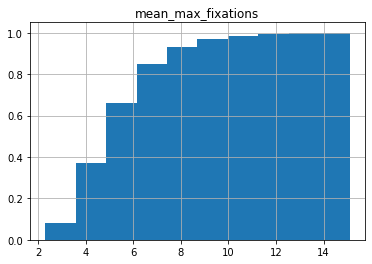

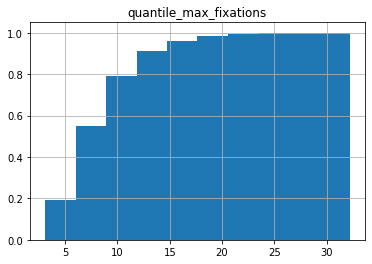

In [145]:


mean_fixations_by_image = ta_df[["image_ids","fixations"]].groupby(["image_ids"]).mean()
mean_fixations_by_image.columns = ["mean_max_fixations"]
mean_fixations_by_image.reset_index()

quantile_fixations_by_image = ta_df[["image_ids","fixations"]].groupby(["image_ids"]).quantile(0.9)
quantile_fixations_by_image.columns = ["quantile_max_fixations"]
quantile_fixations_by_image.reset_index()


mean_fixations_by_image.hist(cumulative=True,density=True)
quantile_fixations_by_image.hist(cumulative=True,density=True)


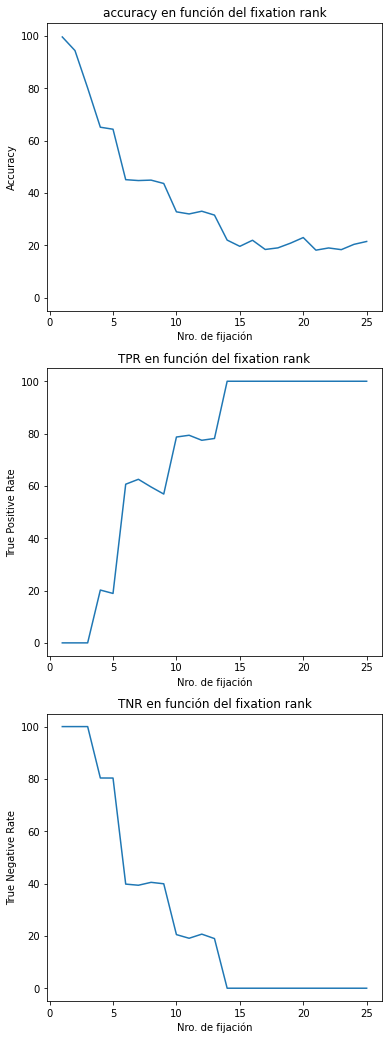

In [155]:
#Baseline Model

input_fixations = np.concatenate((ta_data["fixations"],tp_data["fixations"]))
predictions = np.empty(shape=0,dtype=np.int32)
for fixation in input_fixations:
    if fixation <4:
        proba=0.0
    elif 4 <= fixation <=5:
        proba = 0.2
    elif 6 <= fixation <= 9:
        proba = 0.6
    elif 10 <= fixation <= 13:
        proba = 0.8
    else:
        proba = 1.0
    predictions = np.append(predictions,np.random.binomial(1,proba))
fig, ax = plt.subplots(3, 1, figsize = (6,18),sharey=True)


input_labels = np.concatenate((ta_data["labels"],tp_data["labels"]))
indexes_by_fix_number = []
acc_by_fix = np.empty(shape=(0,))
tpr_by_fix = np.empty(shape=(0,))
tnr_by_fix = np.empty(shape=(0,))

for j in range(1,26):
    indexes_by_fix_number.append(np.where(input_fixations == j)[0])
for array in indexes_by_fix_number:
    labels_by_fix = input_labels[array]
    positives = np.sum(labels_by_fix == 1)
    negatives = np.sum(labels_by_fix == 0)
    predictions_by_fix = predictions[array]
    true_positives = np.sum(np.logical_and(predictions_by_fix,labels_by_fix))
    true_negatives = np.sum(np.logical_not(np.logical_or(predictions_by_fix,labels_by_fix)))
    total = positives + negatives
    correct = true_positives + true_negatives
    
    tpr_by_fix = np.append(tpr_by_fix,100.0 * true_positives / positives)
    tnr_by_fix = np.append(tnr_by_fix,100.0 * true_negatives / negatives)
    acc_by_fix = np.append(acc_by_fix,100.0 * correct / total)
  
ax[0].plot(range(1,26),acc_by_fix)
ax[0].set_title(f"accuracy en función del fixation rank")
ax[0].set_xlabel("Nro. de fijación")
ax[0].set_ylabel("Accuracy")
ax[1].plot(range(1,26),tpr_by_fix)
ax[1].set_title(f"TPR en función del fixation rank")
ax[1].set_xlabel("Nro. de fijación")
ax[1].set_ylabel("True Positive Rate")
ax[2].plot(range(1,26),tnr_by_fix)
ax[2].set_title(f"TNR en función del fixation rank")
ax[2].set_xlabel("Nro. de fijación")
ax[2].set_ylabel("True Negative Rate");


In [147]:
continue_labels_indexes = np.where(labels == 0)[0]
stop_labels_indexes = np.where(labels == 1)[0]
negatives = len(continue_labels_indexes)
positives = len(stop_labels_indexes)
total= positives+negatives
print(total)

print(100.0*positives/total)
print(100.0*negatives/total)

128900
13.520558572536851
86.47944142746314


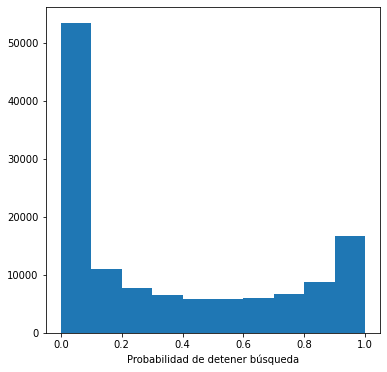

In [148]:
#distribuciones generales

fig, ax = plt.subplots(1, 1, figsize = (6,6))

ax.hist(outputs)

ax.set_xlabel("Probabilidad de detener búsqueda");
    


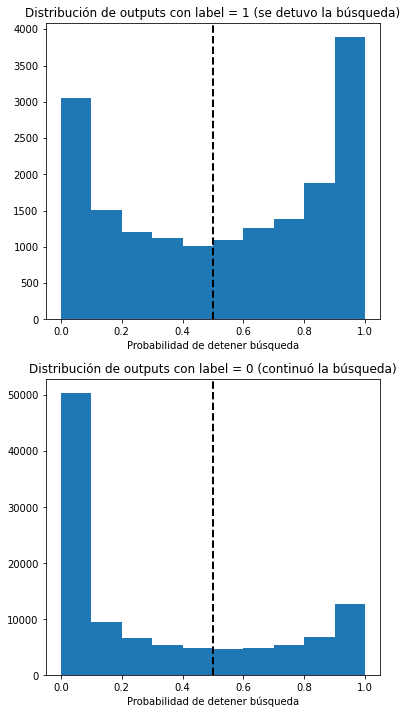

In [149]:
#distribuciones por label
fig, ax = plt.subplots(2, 1, figsize = (6,12))


continue_labels_indexes = np.where(labels == 0)[0]
stop_labels_indexes = np.where(labels == 1)[0]
stop_outputs = outputs[stop_labels_indexes]
continue_outputs = outputs[continue_labels_indexes]
ax[0].hist(stop_outputs)
ax[0].set_title(f"Distribución de outputs con label = 1 (se detuvo la búsqueda)")
ax[0].set_xlabel("Probabilidad de detener búsqueda")
ax[1].hist(continue_outputs)
ax[1].set_title(f"Distribución de outputs con label = 0 (continuó la búsqueda)")
ax[1].set_xlabel("Probabilidad de detener búsqueda")
ax[1].axvline(x=[0.5], color='black', ls='--', lw=2, label='umbral de decisión')
ax[0].axvline(x=[0.5], color='black', ls='--', lw=2, label='umbral de decisión');


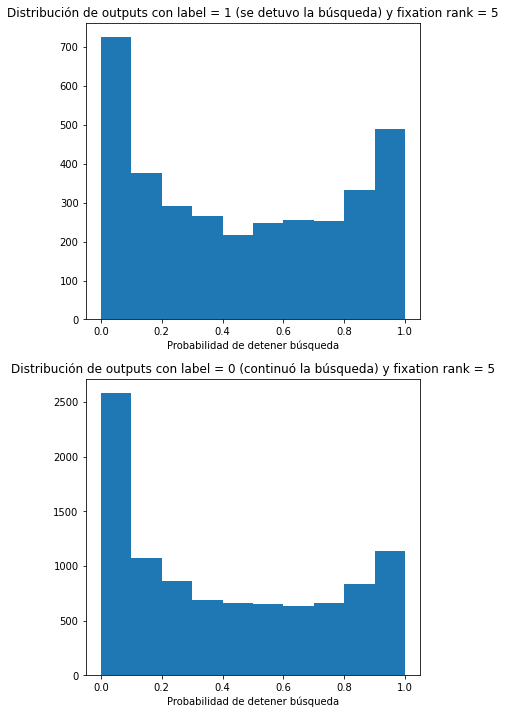

In [150]:
#distribuciones por número de fijación
fig, ax = plt.subplots(2, 1, figsize = (6,12))

fixation = 5
fixation_indexes = np.where(fixations == fixation)[0]     
continue_labels_indexes = np.where(labels == 0)[0]
stop_labels_indexes = np.where(labels == 1)[0]
continue_labels_indexes = np.intersect1d(continue_labels_indexes,fixation_indexes)
stop_labels_indexes = np.intersect1d(stop_labels_indexes,fixation_indexes)    
stop_outputs = outputs[stop_labels_indexes]
continue_outputs = outputs[continue_labels_indexes]    
ax[0].hist(stop_outputs)
ax[0].set_title(f"Distribución de outputs con label = 1 (se detuvo la búsqueda) y fixation rank = {fixation}")
ax[0].set_xlabel("Probabilidad de detener búsqueda")
ax[1].hist(continue_outputs)
ax[1].set_title(f"Distribución de outputs con label = 0 (continuó la búsqueda) y fixation rank = {fixation}")
ax[1].set_xlabel("Probabilidad de detener búsqueda");

/tmp/ipykernel_390774/4211099830.py:23: RuntimeWarning: invalid value encountered in double_scalars
  tpr_by_fix = np.append(tpr_by_fix,100.0 * true_positives / positives)


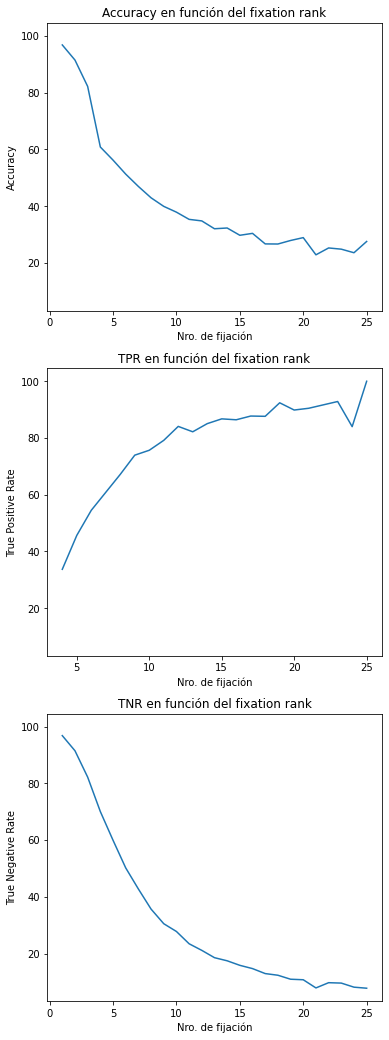

In [151]:
#métricas por número de fijación

fig, ax = plt.subplots(3, 1, figsize = (6,18),sharey=True)

indexes_by_fix_number = []
acc_by_fix = np.empty(shape=(0,))
tpr_by_fix = np.empty(shape=(0,))
tnr_by_fix = np.empty(shape=(0,))

for j in range(1,26):
    indexes_by_fix_number.append(np.where(fixations == j)[0])
for array in indexes_by_fix_number:
    outputs_by_fix = outputs[array]
    labels_by_fix = labels[array]
    positives = np.sum(labels_by_fix == 1)
    negatives = np.sum(labels_by_fix == 0)
    predictions_by_fix = outputs_by_fix >= 0.5 #al tener nuevos resultados meter sigmoidea acá
    true_positives = np.sum(np.logical_and(predictions_by_fix,labels_by_fix))
    true_negatives = np.sum(np.logical_not(np.logical_or(predictions_by_fix,labels_by_fix)))
    total = positives + negatives
    correct = true_positives + true_negatives
    
    tpr_by_fix = np.append(tpr_by_fix,100.0 * true_positives / positives)
    tnr_by_fix = np.append(tnr_by_fix,100.0 * true_negatives / negatives)
    acc_by_fix = np.append(acc_by_fix,100.0 * correct / total)

ax[0].plot(range(1,26),acc_by_fix)
ax[0].set_title(f"Accuracy en función del fixation rank")
ax[0].set_xlabel("Nro. de fijación")
ax[0].set_ylabel("Accuracy")
ax[1].plot(range(1,26),tpr_by_fix)
ax[1].set_title(f"TPR en función del fixation rank")
ax[1].set_xlabel("Nro. de fijación")
ax[1].set_ylabel("True Positive Rate")
ax[2].plot(range(1,26),tnr_by_fix)
ax[2].set_title(f"TNR en función del fixation rank")
ax[2].set_xlabel("Nro. de fijación")
ax[2].set_ylabel("True Negative Rate");



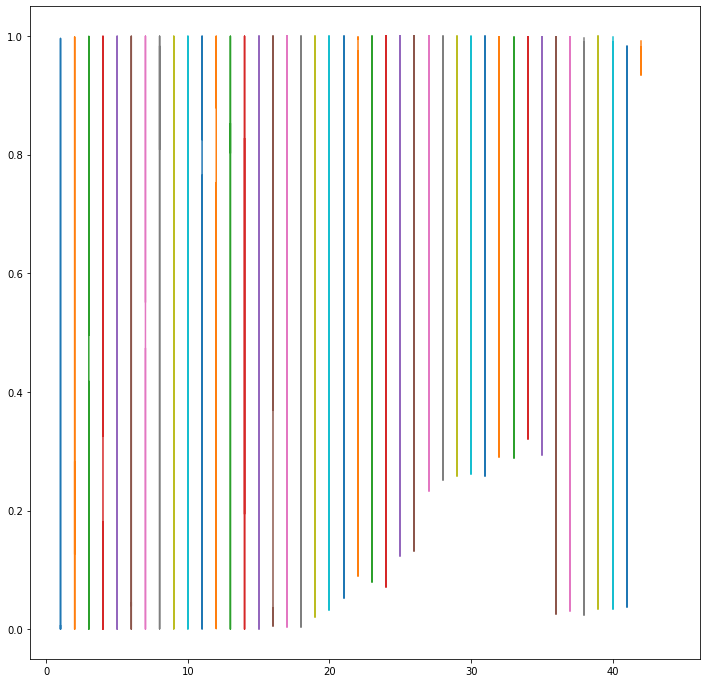

In [152]:
#evolución de valor de output por cada scanpath

fig, ax = plt.subplots(1, 1, figsize = (12,12),sharey=True)

sort_idx = np.argsort(scanpath_ids)
a_sorted = fixations[sort_idx]
unq_first = np.concatenate(([True], a_sorted[1:] != a_sorted[:-1]))
unq_items = a_sorted[unq_first]
unq_count = np.diff(np.nonzero(unq_first)[0])
grouped_indexes = np.split(sort_idx, np.cumsum(unq_count))

for indexes in grouped_indexes:
    ax.plot(fixations[indexes],outputs[indexes])

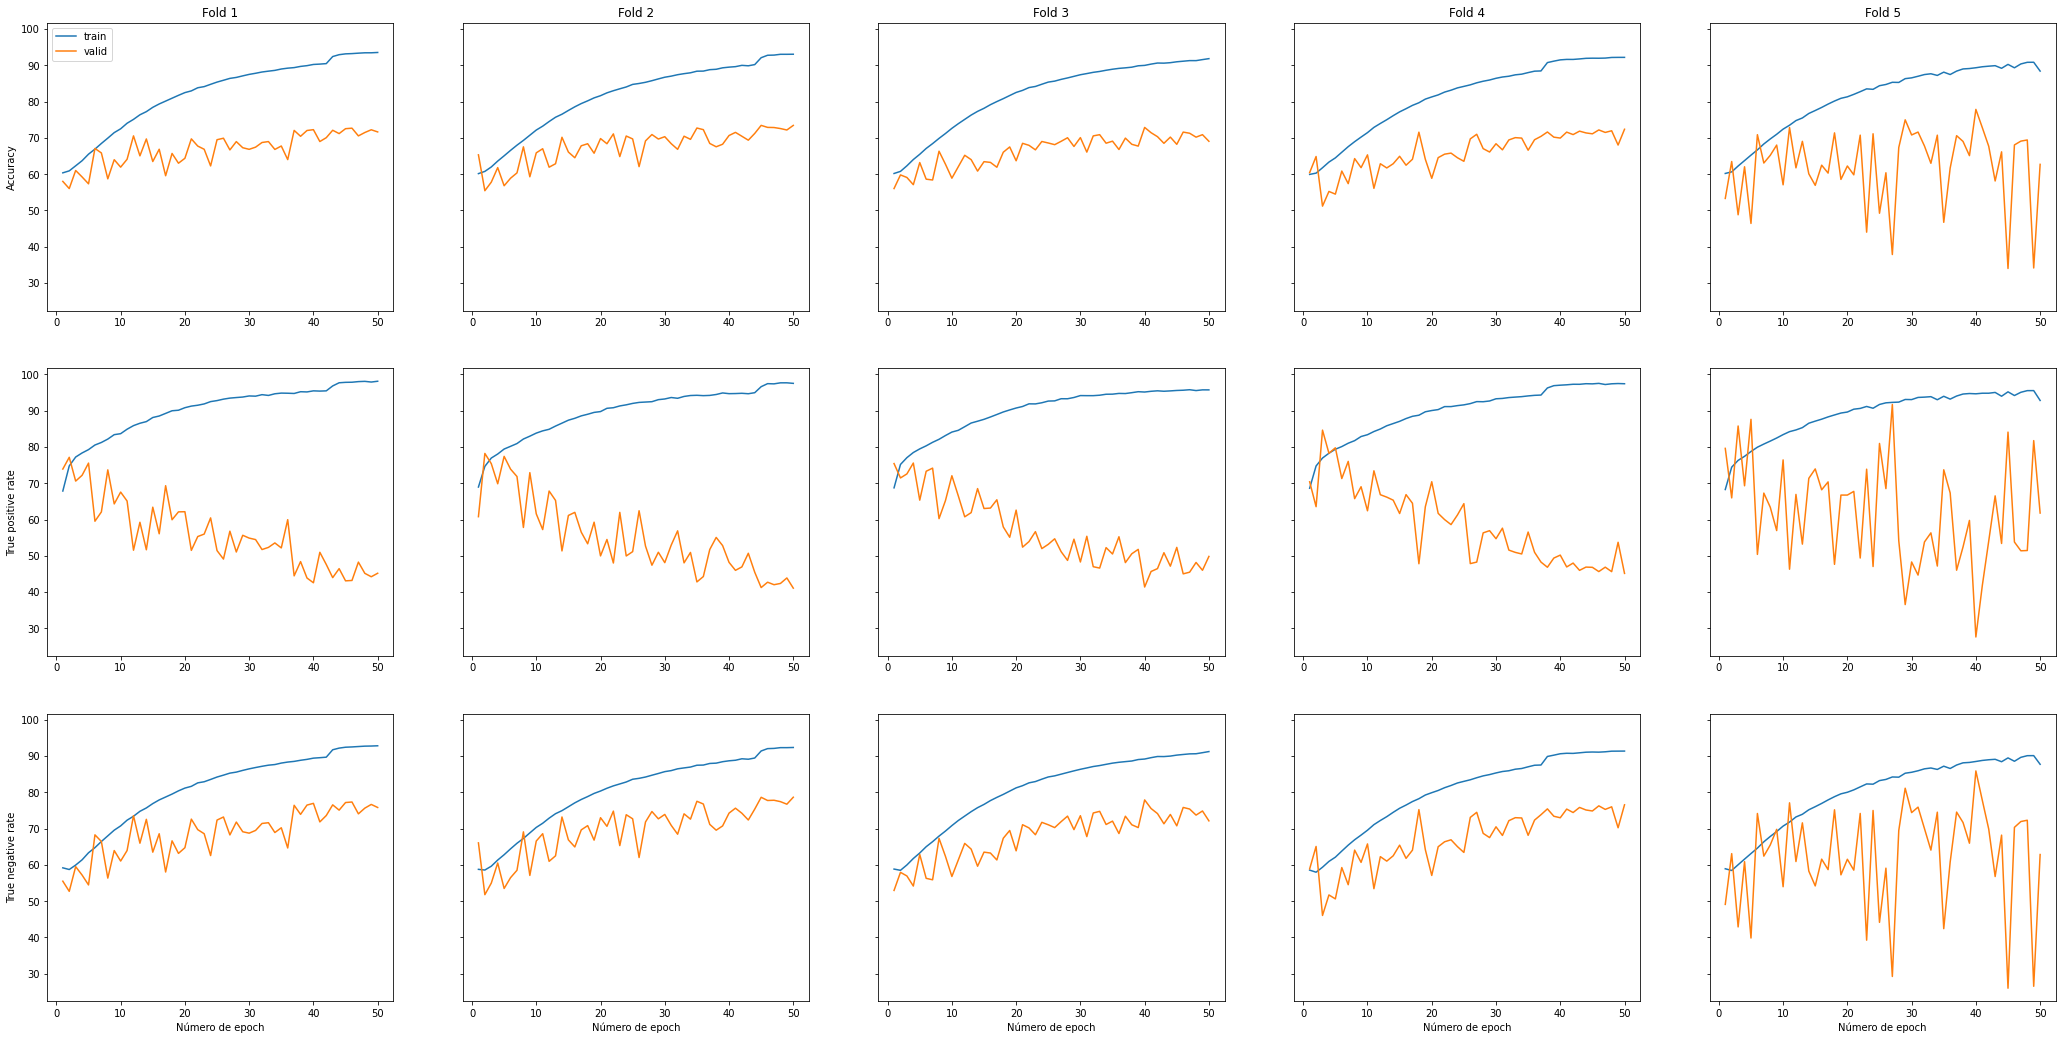

In [153]:
cross_val_data = pd.read_csv("training_info_nuevo_enfoque_sin_fixation_rank.csv")
fig, ax = plt.subplots(3, 5, figsize = (36,18),sharey=True)
ax[0][0].set_ylabel("Accuracy")
ax[1][0].set_ylabel("True positive rate")
ax[2][0].set_ylabel("True negative rate")
for i in range(1,6):
    fold_data = cross_val_data[cross_val_data['n_fold']==i]
    training_data = fold_data[fold_data['train']==1.0]
    valid_data = fold_data[fold_data['valid']==1.0]
    ax[0][i-1].set_title(f"Fold {i}")

    ax[2][i-1].set_xlabel("Número de epoch")
    ax[0][i-1].plot(training_data['n_epoch'], training_data['acc'])
    ax[1][i-1].plot(training_data['n_epoch'],training_data['tpr'])
    ax[2][i-1].plot(training_data['n_epoch'],training_data['tnr'])
    ax[0][i-1].plot(valid_data['n_epoch'],valid_data['acc'])
    ax[1][i-1].plot(valid_data['n_epoch'],valid_data['tpr'])
    ax[2][i-1].plot(valid_data['n_epoch'],valid_data['tnr'])


ax[0][0].legend(["train","valid"]);
    

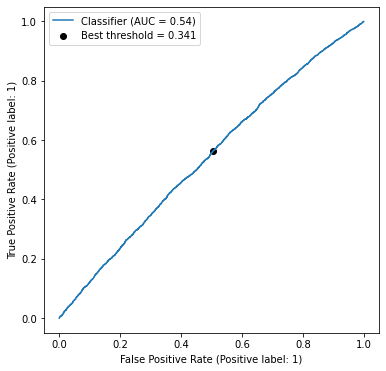

In [154]:

fig, ax = plt.subplots(1, 1, figsize = (6,6))

fixation_indexes = np.where((fixations ==5) )[0] 
filtered_labels = labels[fixation_indexes]
filtered_outputs = outputs[fixation_indexes]
RocCurveDisplay.from_predictions(filtered_labels, filtered_outputs,ax=ax)
fpr, tpr, thresholds = roc_curve(filtered_labels, filtered_outputs)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
ax.scatter(fpr[ix], tpr[ix], marker='o', color='black', label=f'Best threshold = %.3f' % (thresholds[ix]))
ax.legend();

